## Method D - Unique Contribution: Ensemble Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

from ecgLoader import load_ecg5000
from tensorflow.keras import layers, models, Input

X_train, X_test, y_train, y_test = load_ecg5000(one_hot=True)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]



Applied one-hot encoding: (3998, 5)


In [2]:
def attention_block(inputs):
    attention = layers.Dense(1, activation='tanh')(inputs)
    attention = layers.Flatten()(attention)
    attention = layers.Activation('softmax')(attention)
    attention = layers.RepeatVector(inputs.shape[-1])(attention)
    attention = layers.Permute([2, 1])(attention)
    return layers.Multiply()([inputs, attention])

def build_cnn_attention_model(input_shape=(140, 1), num_classes=5):
    inputs = Input(shape=input_shape)
    x = layers.Conv1D(64, kernel_size=5, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = attention_block(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = layers.Conv1D(filters, kernel_size, padding='same', strides=stride)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = layers.Conv1D(filters, kernel_size=1, padding='same')(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_resnet_model(input_shape=(140, 1), num_classes=5):
    inputs = Input(shape=input_shape)
    x = layers.Conv1D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

    x = residual_block(x, 64)
    x = residual_block(x, 128)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [3]:
modelA = build_cnn_attention_model()
modelB = build_resnet_model()

print("Training CNN + Attention (Method A)...")
modelA.fit(X_train, y_train, validation_split=0.2, epochs=15, batch_size=64)

print("Training Improved ResNet (Method B)...")
modelB.fit(X_train, y_train, validation_split=0.2, epochs=15, batch_size=64)


Training CNN + Attention (Method A)...
Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.6647 - loss: 1.0255 - val_accuracy: 0.9762 - val_loss: 0.0977
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9829 - loss: 0.0783 - val_accuracy: 0.9787 - val_loss: 0.0873
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9852 - loss: 0.0537 - val_accuracy: 0.9762 - val_loss: 0.0899
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9820 - loss: 0.0632 - val_accuracy: 0.9762 - val_loss: 0.1029
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9883 - loss: 0.0467 - val_accuracy: 0.9787 - val_loss: 0.0668
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9873 - loss: 0.0496 - val_accuracy: 0.9812 - val_loss: 0.0585
Epoch 7/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9881 - loss: 0.0443 - val_accuracy: 0.9837 - val_loss: 0.0561
Epoch 8/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9890 - 

In [4]:
y_pred_A = modelA.predict(X_test)
y_pred_B = modelB.predict(X_test)

ensemble_probs = (y_pred_A + y_pred_B) / 2.0
ensemble_preds = np.argmax(ensemble_probs, axis=1)
y_true = np.argmax(y_test, axis=1)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       591
           4       0.99      1.00      1.00       409

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



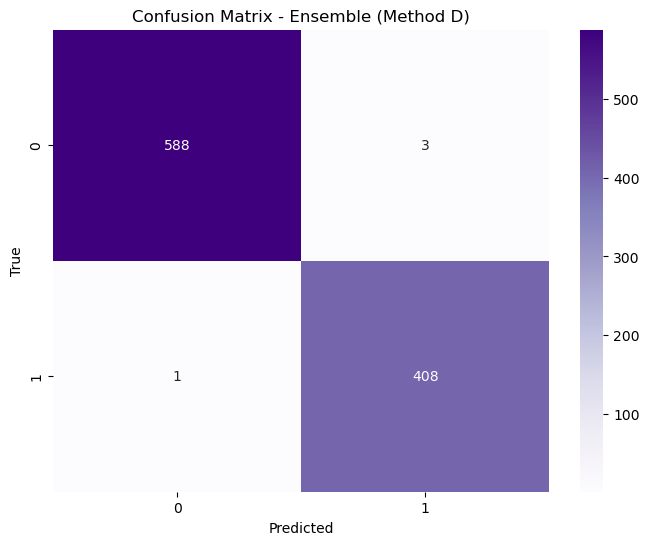

In [5]:
# Classification Report
print(classification_report(y_true, ensemble_preds))

# Confusion Matrix
cm = confusion_matrix(y_true, ensemble_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Ensemble (Method D)')
plt.show()


## Let's try another dataset

In [33]:
from ecgLoader import load_heartbeat_dataset

X_train, X_test, y_train, y_test = load_heartbeat_dataset(one_hot=True)
print(X_train.shape, y_train.shape)

(87556, 187, 1) (87556, 5)


In [34]:
def build_cnn_attention_model_heartbeat(input_shape=(187, 1), num_classes=5):
    inputs = Input(shape=input_shape)
    x = layers.Conv1D(64, kernel_size=5, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = attention_block(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_resnet_model_heartbeat(input_shape=(187, 1), num_classes=5):
    inputs = Input(shape=input_shape)
    x = layers.Conv1D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

    x = residual_block(x, 64)
    x = residual_block(x, 128)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [35]:
model_a = build_cnn_attention_model_heartbeat(input_shape=(187, 1), num_classes=5)
model_b = build_resnet_model_heartbeat(input_shape=(187, 1), num_classes=5)


history_a = model_a.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=64)
history_b = model_b.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=64)

y_pred_a = model_a.predict(X_test)
y_pred_b = model_b.predict(X_test)

ensemble_probs = (y_pred_a + y_pred_b) / 2.0
ensemble_preds = np.argmax(ensemble_probs, axis=1)
y_true = np.argmax(y_test, axis=1)


Epoch 1/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8962 - loss: 0.4110 - val_accuracy: 0.9583 - val_loss: 0.1564
Epoch 2/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.9570 - loss: 0.1587 - val_accuracy: 0.9672 - val_loss: 0.1222
Epoch 3/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.9680 - loss: 0.1232 - val_accuracy: 0.9684 - val_loss: 0.1196
Epoch 4/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.9709 - loss: 0.1060 - val_accuracy: 0.9720 - val_loss: 0.1040
Epoch 5/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.9725 - loss: 0.0994 - val_accuracy: 0.9745 - val_loss: 0.0944
Epoch 6/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.9757 - loss: 0.0836 - val_accuracy: 0.9753 - val_loss: 0.0901
Epoch 7/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9791 - loss: 0.0753 - val_accuracy: 0.9772 - val_loss: 0.0815
Epoch 8/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.9782 -


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     18160
           1       0.99      0.66      0.79       535
           2       0.98      0.92      0.95      1402
           3       0.87      0.74      0.80       158
           4       0.99      0.99      0.99      1635

    accuracy                           0.98     21890
   macro avg       0.96      0.86      0.90     21890
weighted avg       0.98      0.98      0.98     21890



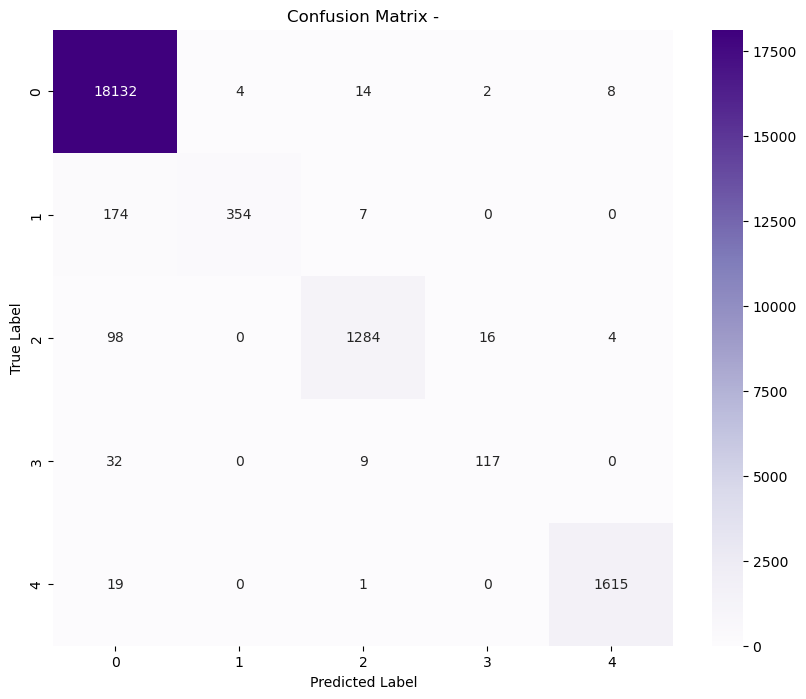

In [36]:
report = classification_report(y_true, ensemble_preds)
conf_matrix = confusion_matrix(y_true, ensemble_preds)



print("\nClassification Report:")
print(report)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples')
plt.title(f'Confusion Matrix -')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()